In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('/content/Ames_Housing_Data.csv')
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
df.drop('PID',axis=1,inplace=True)

# Dataframe the shape
Dataframe contains the shape 

In [4]:
df.shape

(2930, 80)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2440 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            198 non-null    object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

In [6]:
df.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766815,472.819734,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760566,215.046549,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


No duplicate records

In [7]:
df.duplicated(df.columns).any()

False

In [8]:
null_values=df.isna().sum()
null_values[null_values>0]

Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

Let's find out the percentage of missing values in a columns and visualize only those having greater then 0 missing values

In [9]:
total_missing_values = df.isnull().sum().sort_values(ascending=False)
percentage =(total_missing_values/len(df))*100
missing_data_df = pd.concat([total_missing_values,percentage], axis=1, keys=['Total','Percentage_of_missing_values'])
missing_data_df.head(10)

,Total,Percentage_of_missing_values
Pool QC,2917,99.556314
Misc Feature,2824,96.382253
Alley,2732,93.242321
Fence,2358,80.477816
Fireplace Qu,1422,48.532423
Lot Frontage,490,16.723549
Garage Cond,159,5.426621
Garage Qual,159,5.426621
Garage Yr Blt,159,5.426621
Garage Finish,159,5.426621


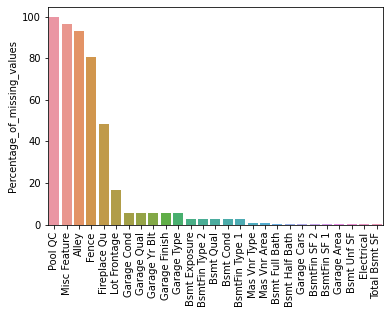

In [10]:
plt.xticks(rotation='90')
sns.barplot(x=missing_data_df[missing_data_df['Percentage_of_missing_values']>0].index, y=missing_data_df[missing_data_df['Percentage_of_missing_values']>0].Percentage_of_missing_values);

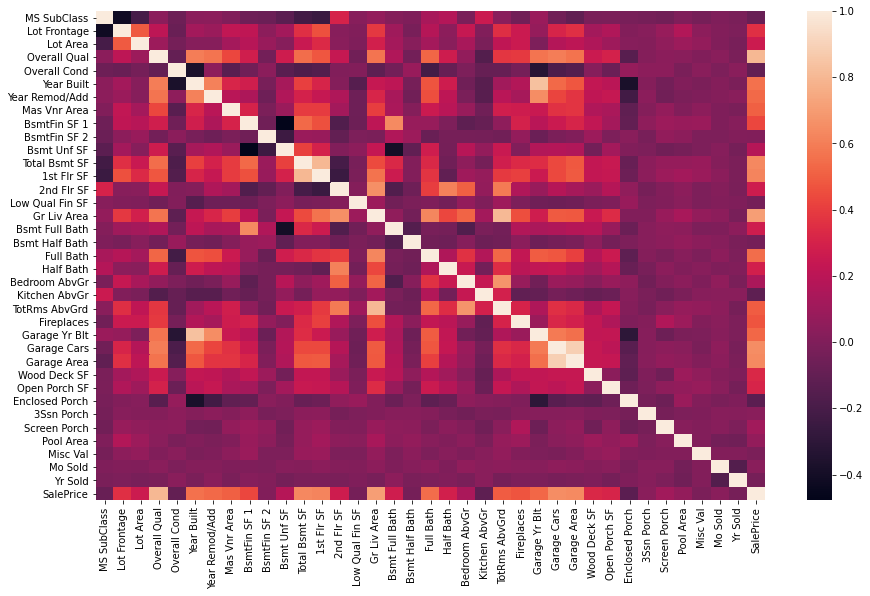

In [11]:
plt.figure(figsize=(15,9))
correlation_matrix=df.corr()
sns.heatmap(correlation_matrix);
plt.show()

In [12]:
df['Total BsmtFin SF']=df['BsmtFin SF 1']+df['BsmtFin SF 2']
df['Bsmt fn']=df['Total Bsmt SF'] - df['Bsmt Unf SF'] # total basement area - unfinished basement area gives finished basement area
df['Total Baths']=df['Bsmt Full Bath']+df['Bsmt Half Bath']+df['Full Bath']+df['Half Bath']
df['Total Porch']=df['Open Porch SF']+df['Enclosed Porch']+df['3Ssn Porch'] +df['Screen Porch']

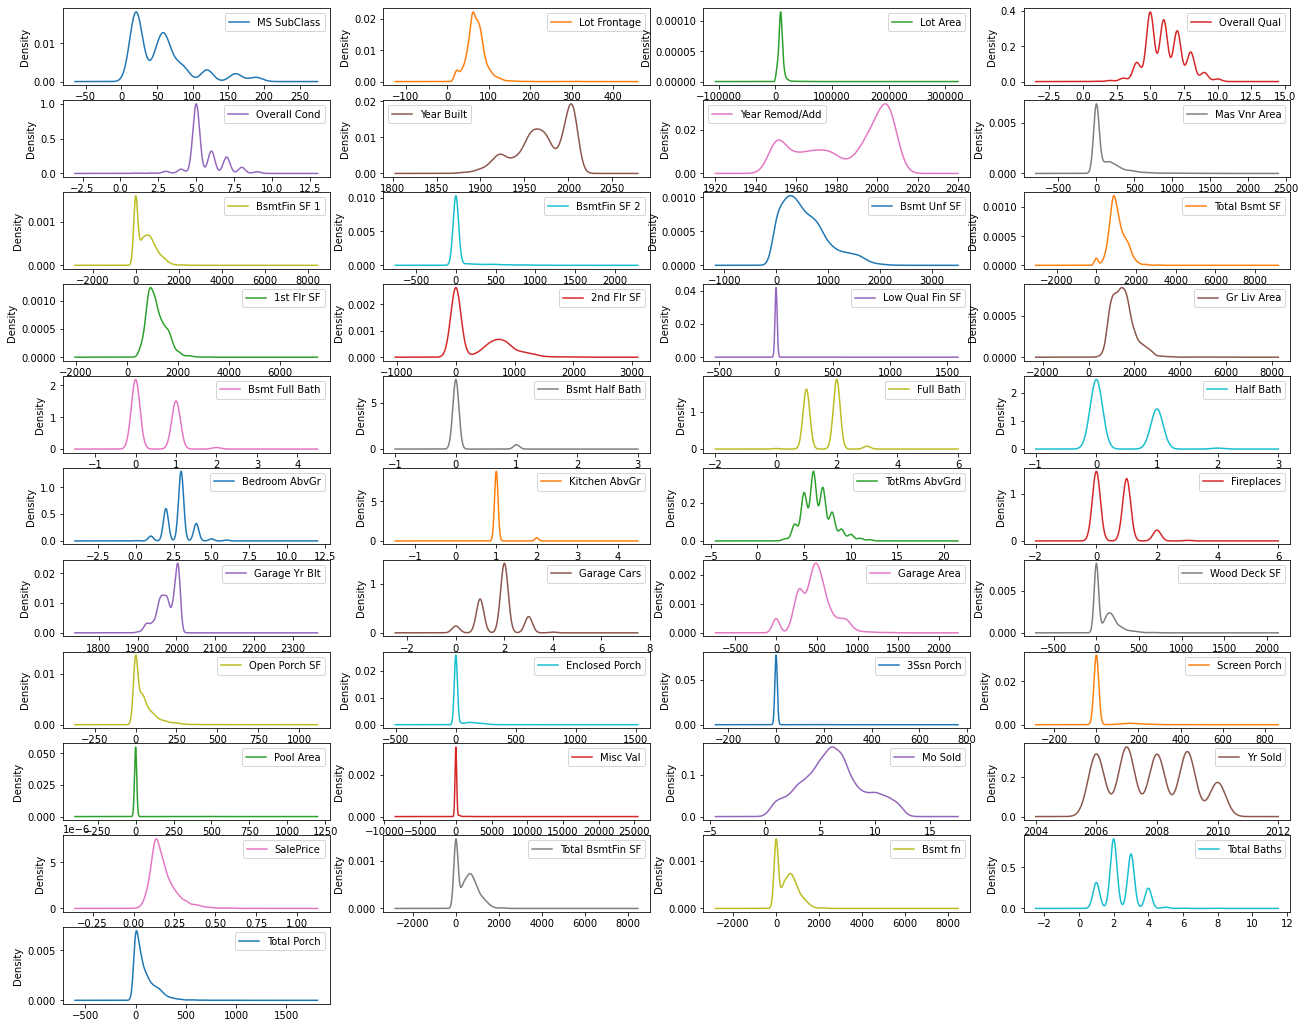

In [13]:
df.plot(kind='density', subplots=True, layout=(12, 4), sharex=False, figsize=(22,20));

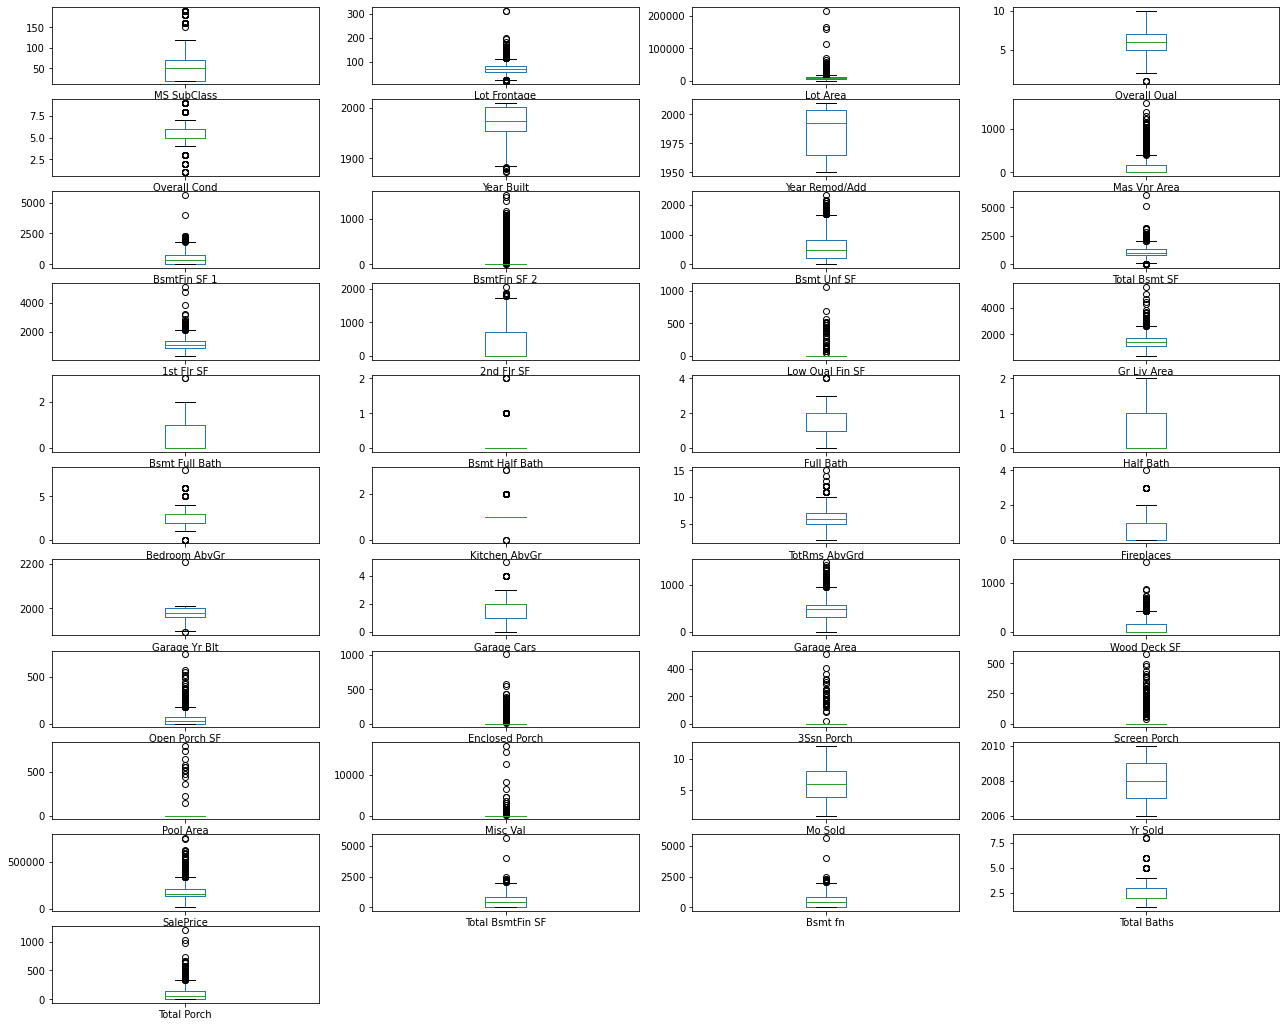

In [14]:
 df.plot(kind='box', subplots=True, layout=(12,4), sharex=False, sharey=False, figsize=(22,20));

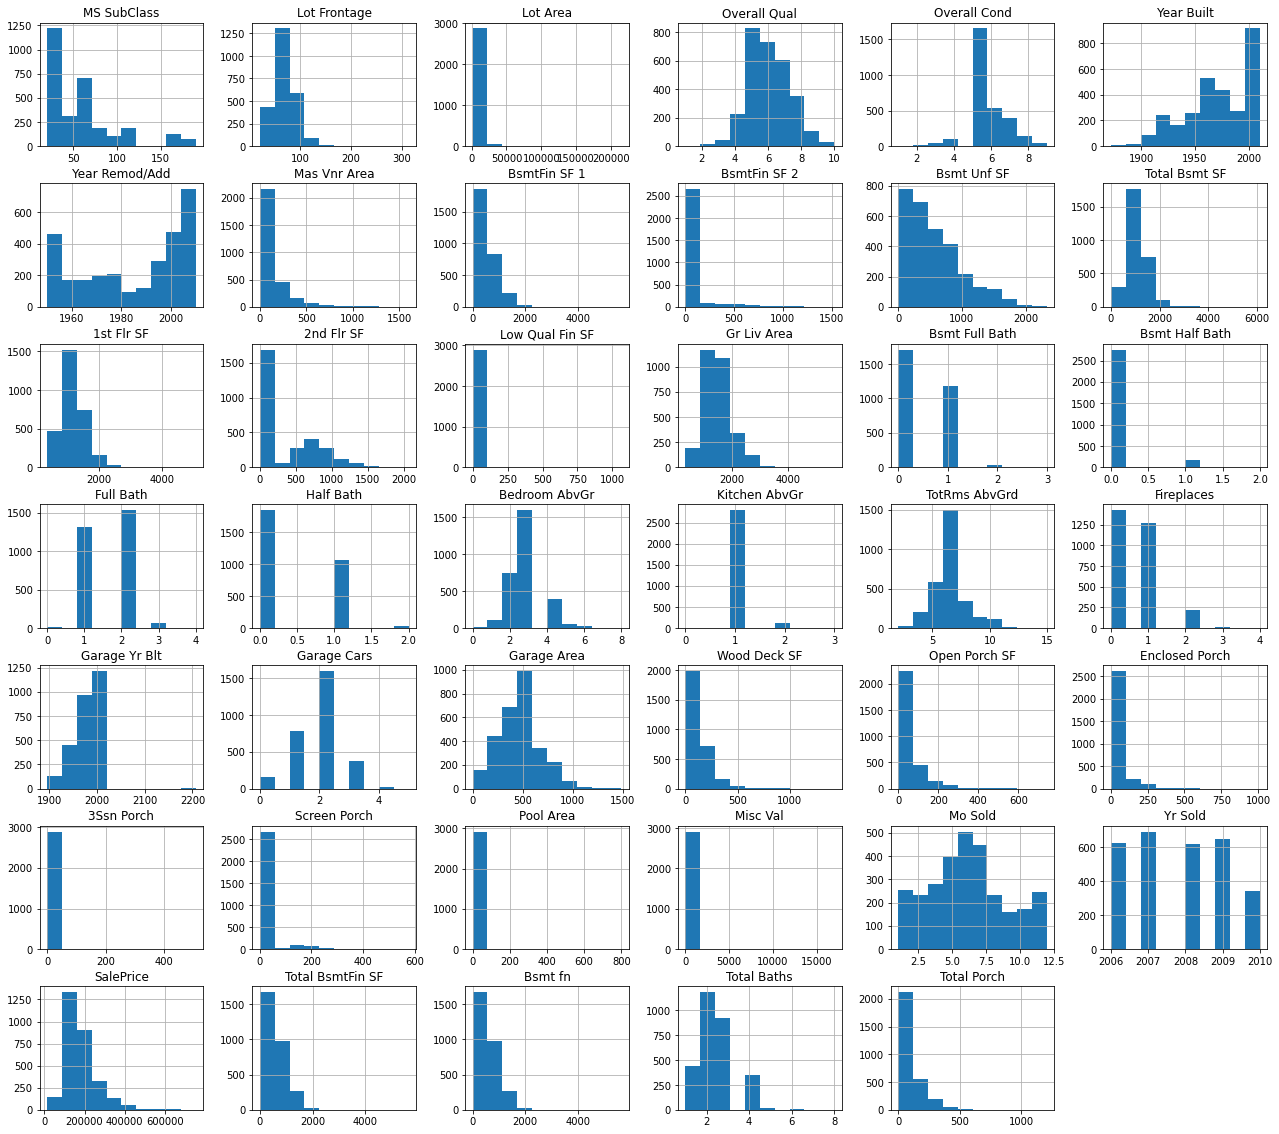

In [15]:
#Histograms
df.hist(figsize=(22,20));

## Seperation of Categorical and Numerical Columns

In [16]:
categorical_columns=[]
numerical_cols=[]
for cols in df.columns:
  if df[cols].dtype==object:
    categorical_columns.append(cols)
  else:
    numerical_cols.append(cols)

Lets seperate the continous and discrete features from the numerical columns
* Discrete data is information that can only take certain values.
* Continuous data is data that can take any value

We simply added the condition if number of unqiue columns are less then 25 then it's discrete

In [17]:
years_cols=['Year Built','Year Remod/Add','Yr Sold','Garage Yr Blt']

In [18]:
discrete_cols=[cols for cols in numerical_cols if (df[cols].nunique()<25) and cols not in years_cols]

In [19]:
discrete_cols

['MS SubClass',
 'Overall Qual',
 'Overall Cond',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Pool Area',
 'Mo Sold',
 'Total Baths']

Continous features are those which aren't in discrete features

In [20]:
continous_cols=[cols for cols in numerical_cols if cols not in discrete_cols+years_cols]
continous_cols

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Misc Val',
 'SalePrice',
 'Total BsmtFin SF',
 'Bsmt fn',
 'Total Porch']

While visualize a histogram we findout that some columns contain -infinity so let's replace it with Null first

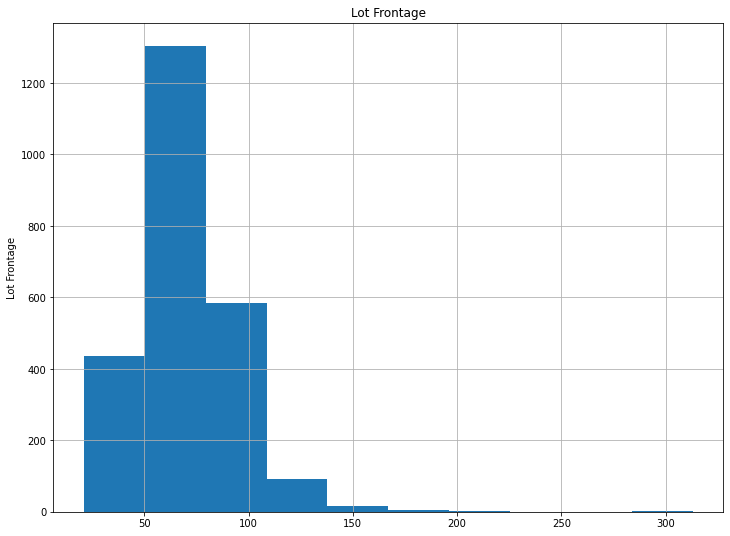

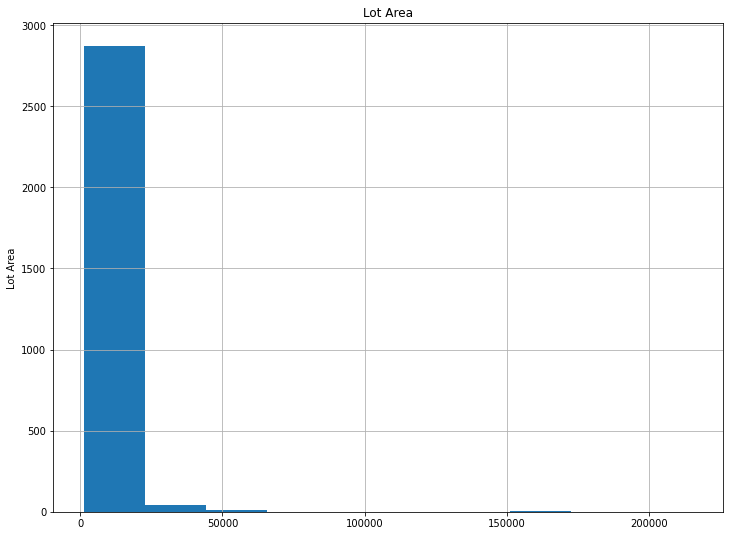

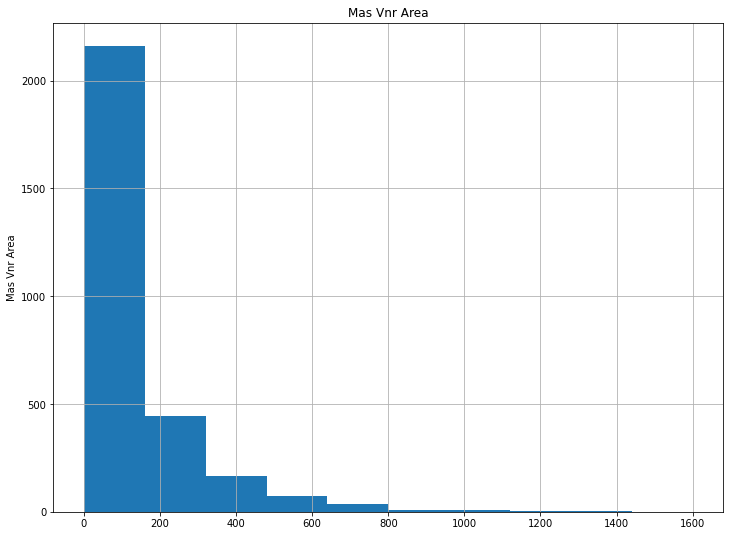

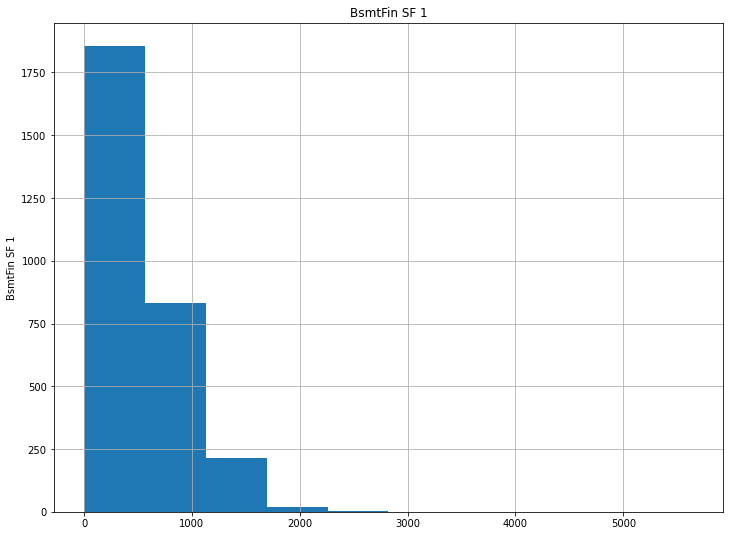

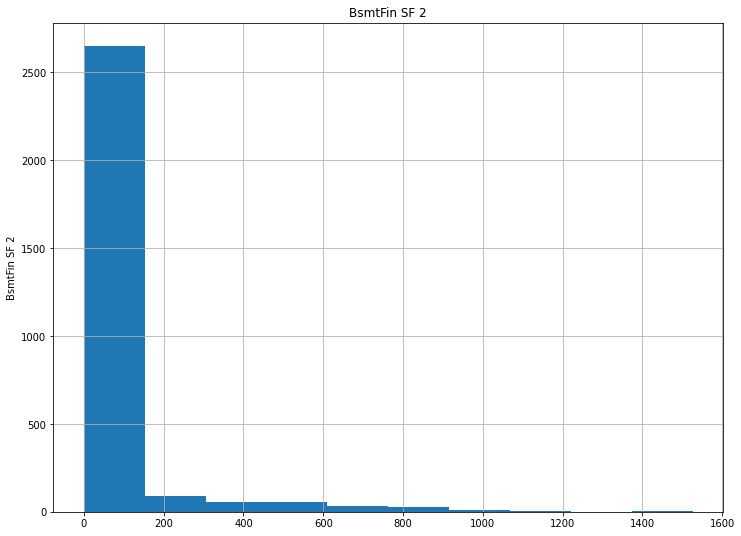

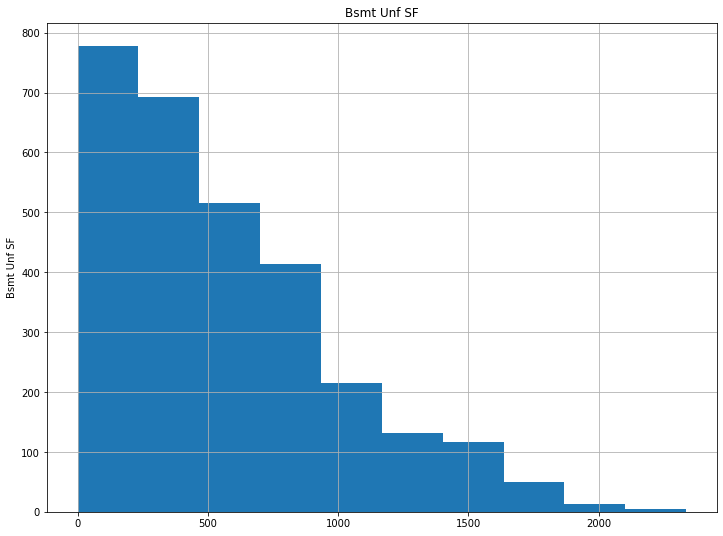

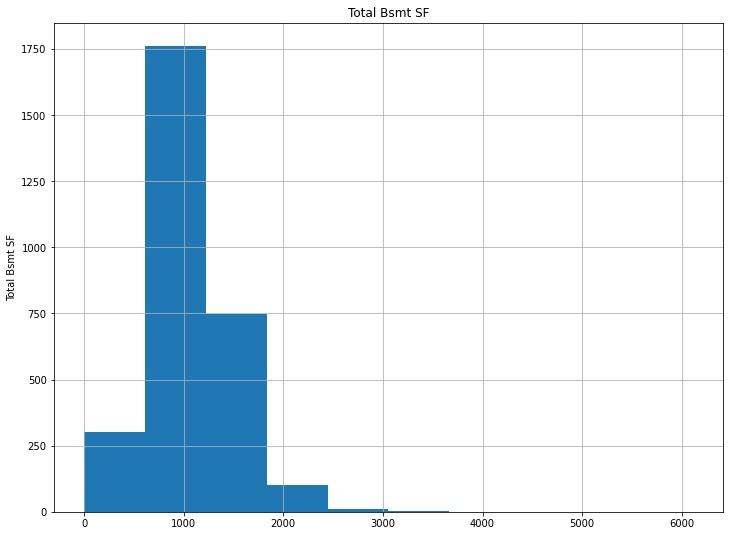

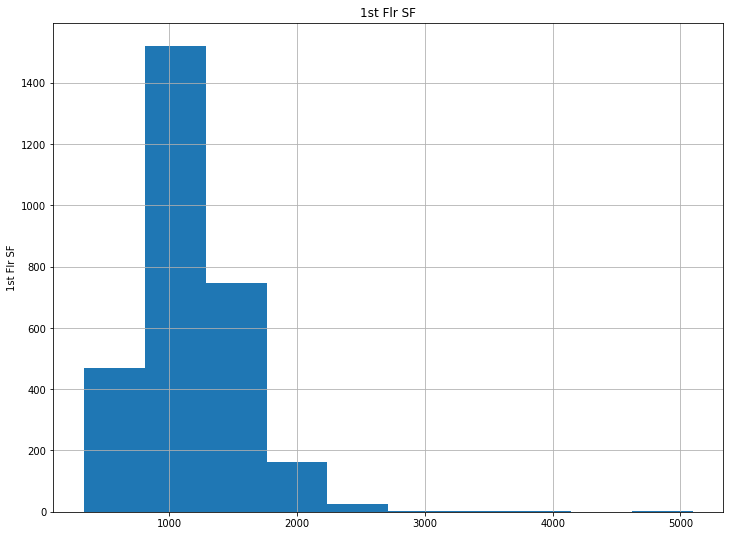

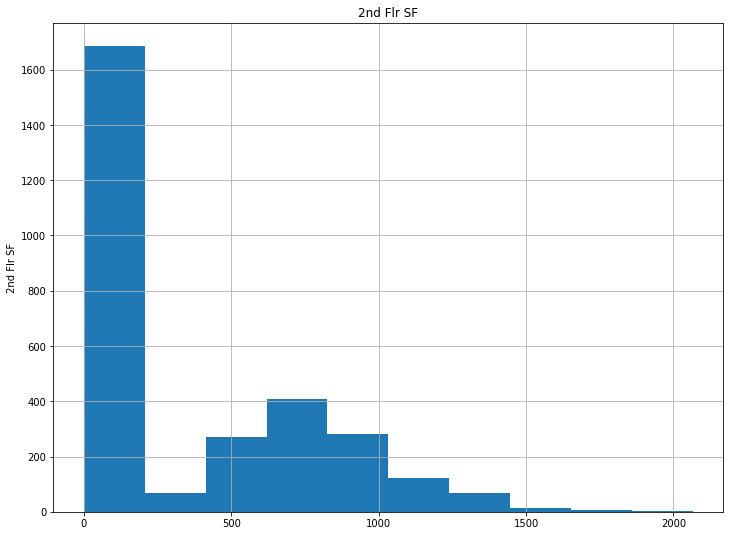

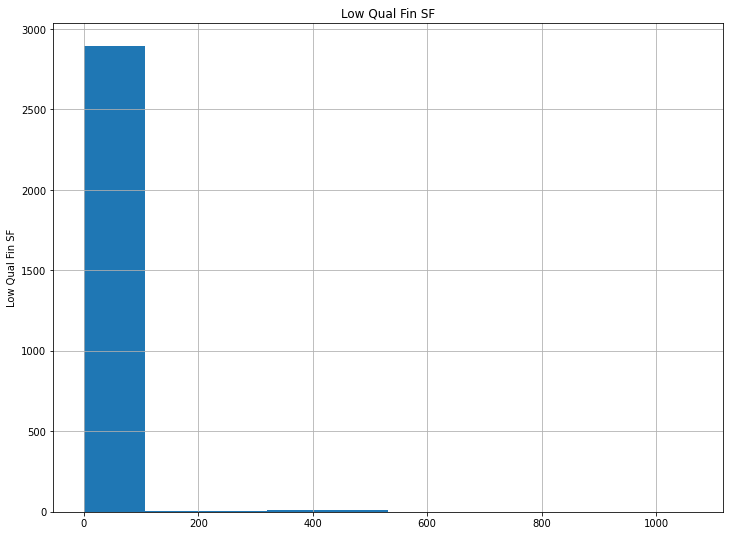

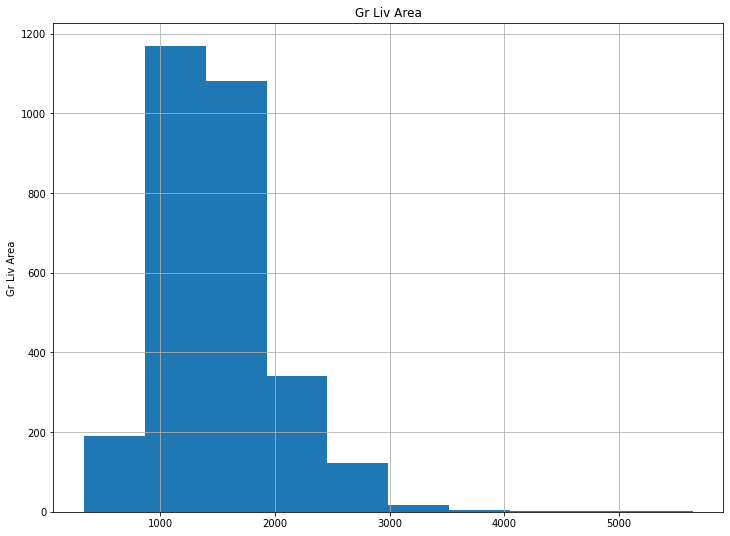

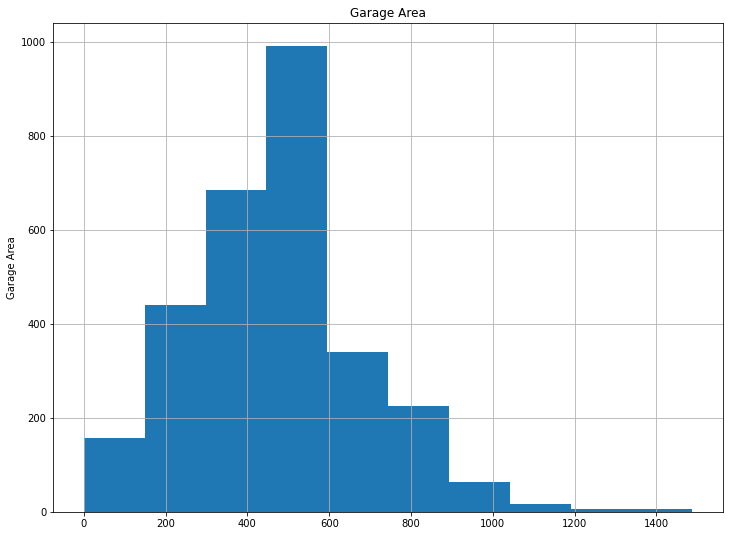

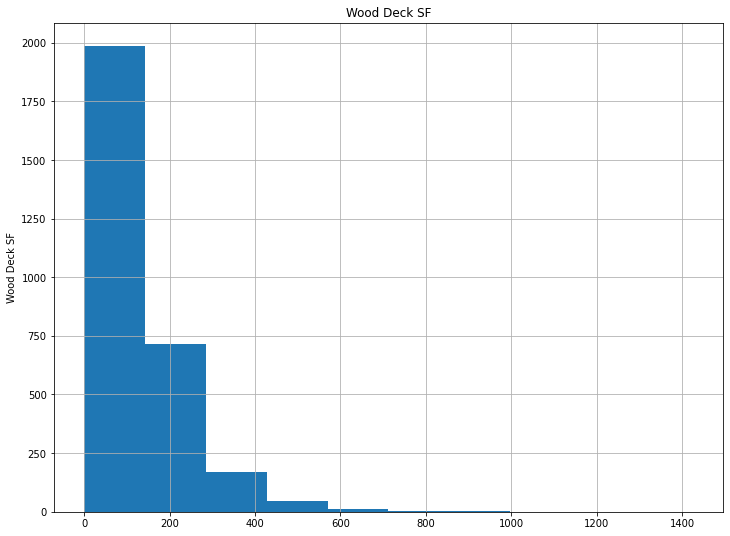

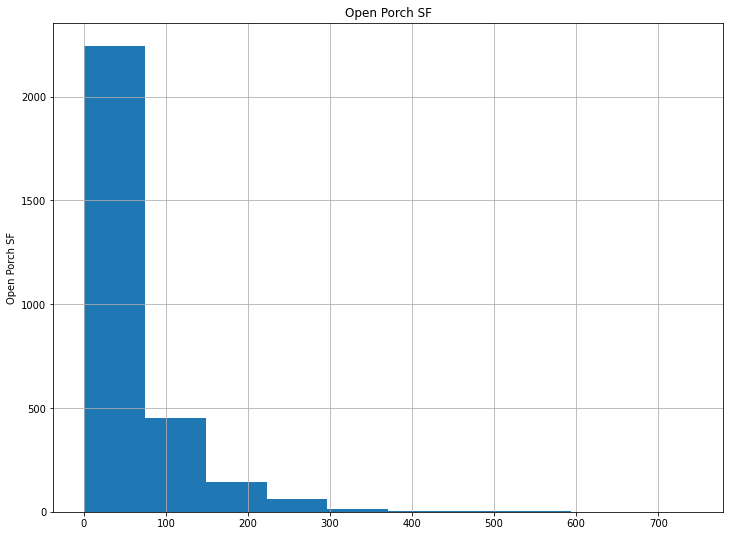

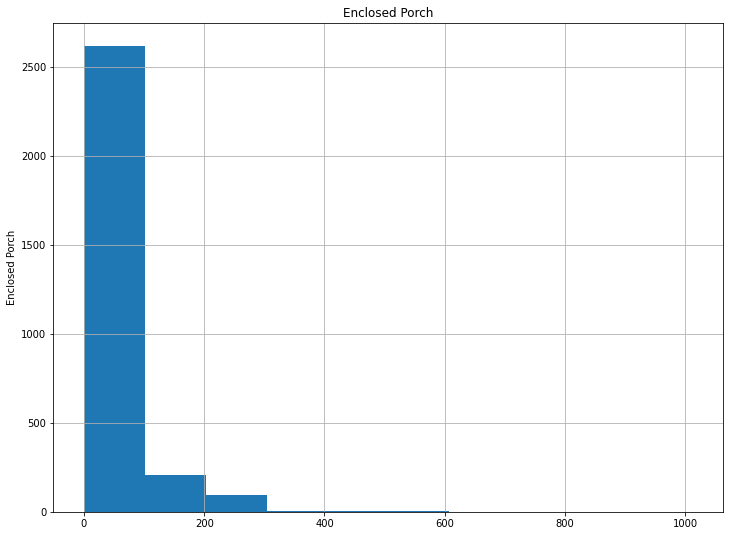

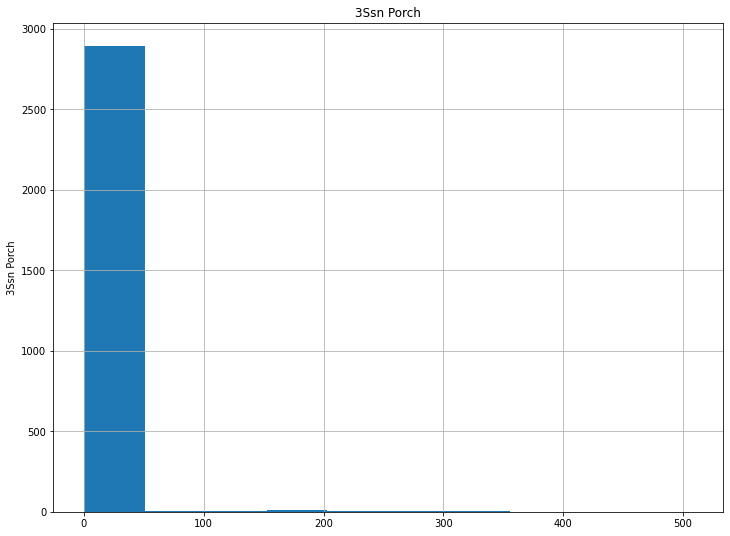

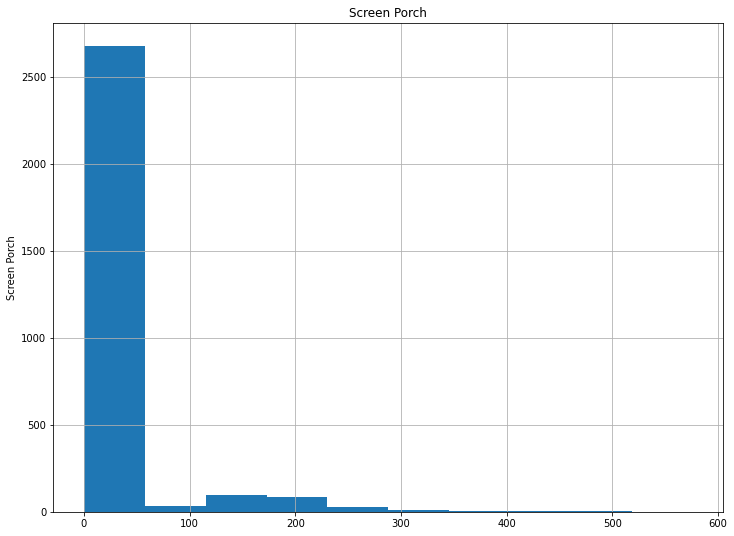

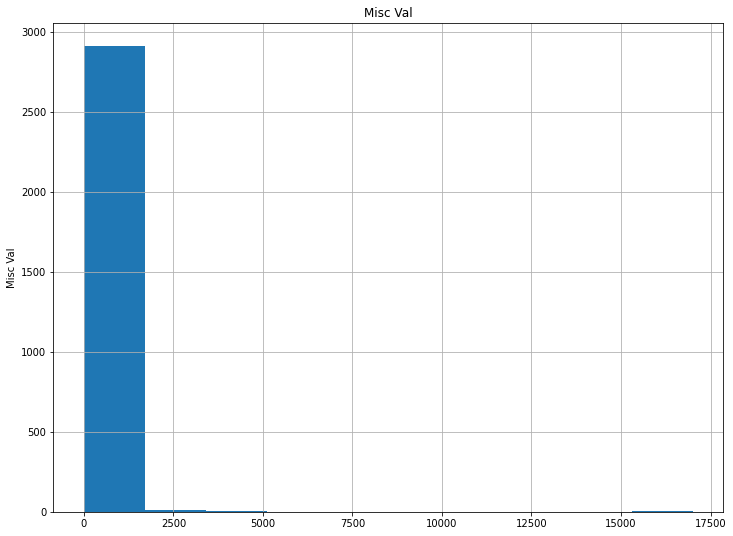

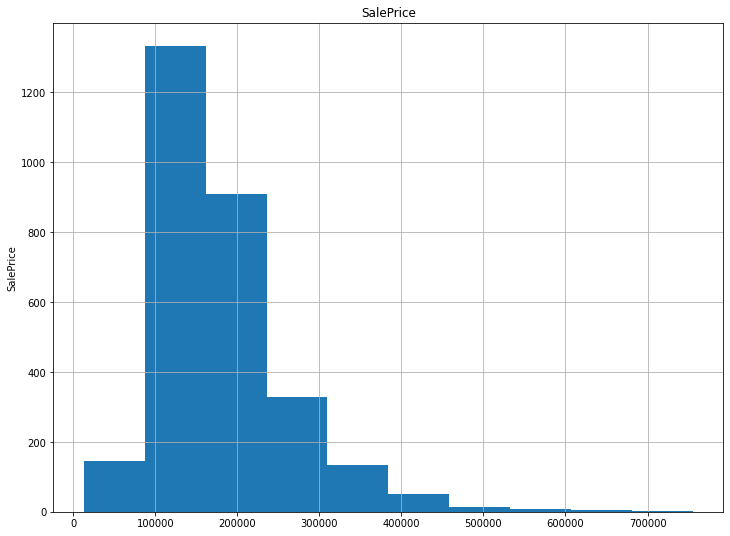

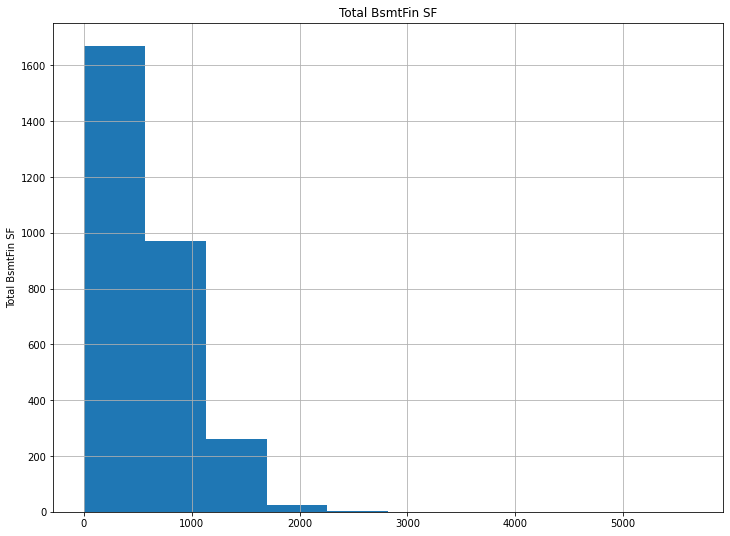

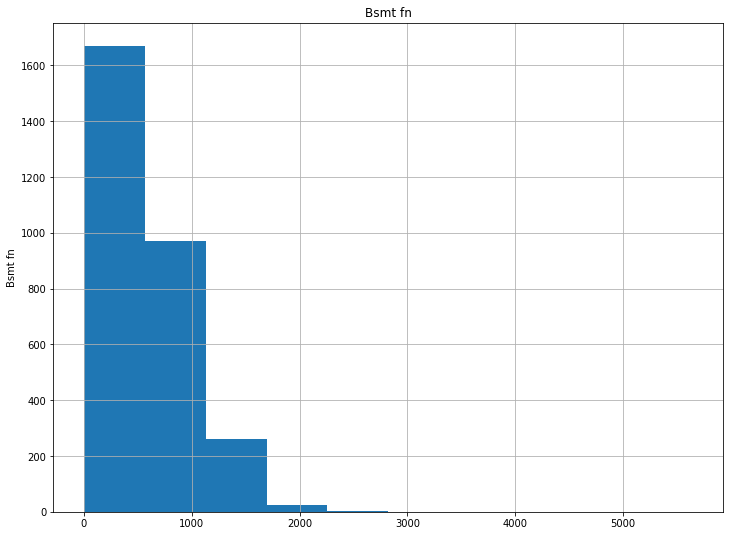

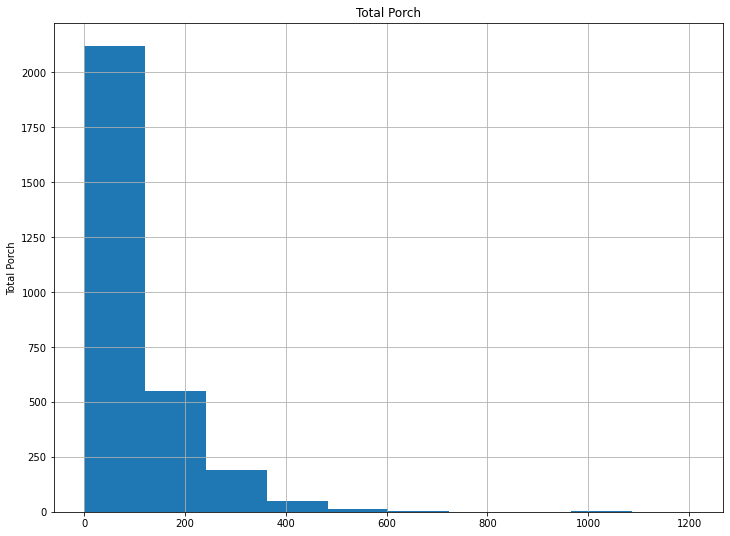

In [21]:
for cols in continous_cols:
  if df[cols].nunique() != 0:
    plt.figure(figsize=(12,9))
    df[cols].hist()
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()
  else:
    pass

As from above we can see that the distribution isn't normal so we applied logarithmic transformation on continous columns

In [22]:
np.log(0)

-inf

As we know log(0) return -infinity so we aren't applying log on 0 values just skipping it

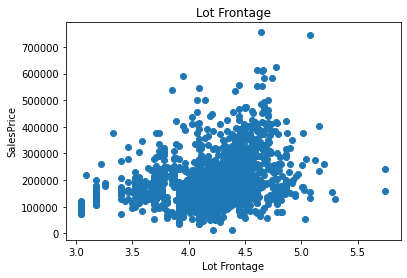

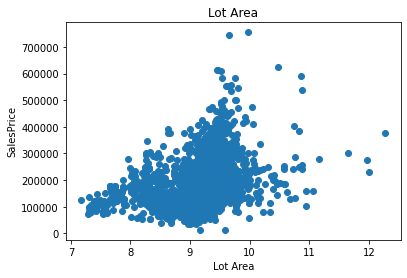

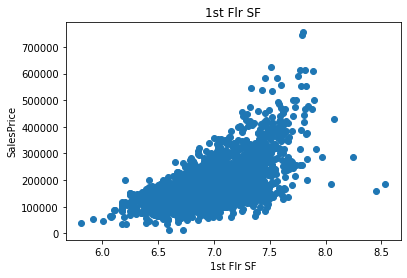

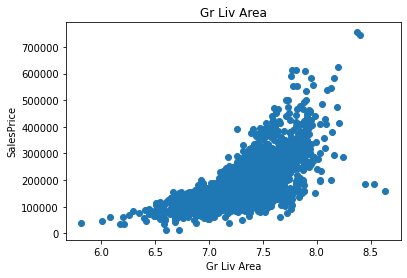

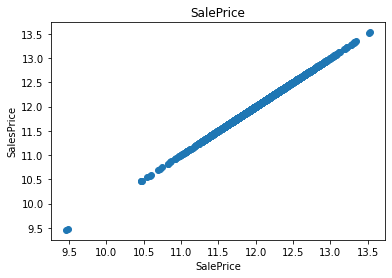

In [23]:
for cols in continous_cols:
  if 0 in df[cols].unique():
        pass
  else:
    df[cols]=np.log(df[cols])
    plt.scatter(df[cols],df['SalePrice'])
    plt.xlabel(cols)
    plt.ylabel('SalesPrice')
    plt.title(cols)
    plt.show()

## Outliers Detection
Similary here we're also appyling the log transformation and skipping the 0 values.
BoxPlot visualization give us better understanding of detecting outliers. As we have also plot it above but it was for all numerical columns. Let's limited it to just continous columns

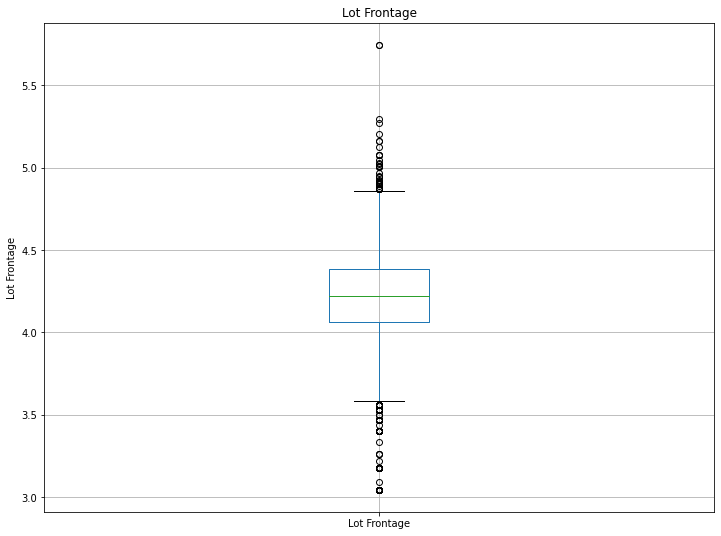

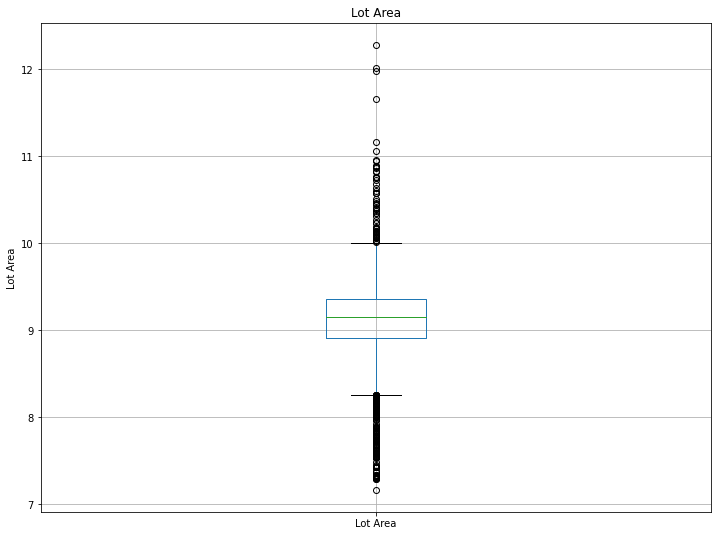

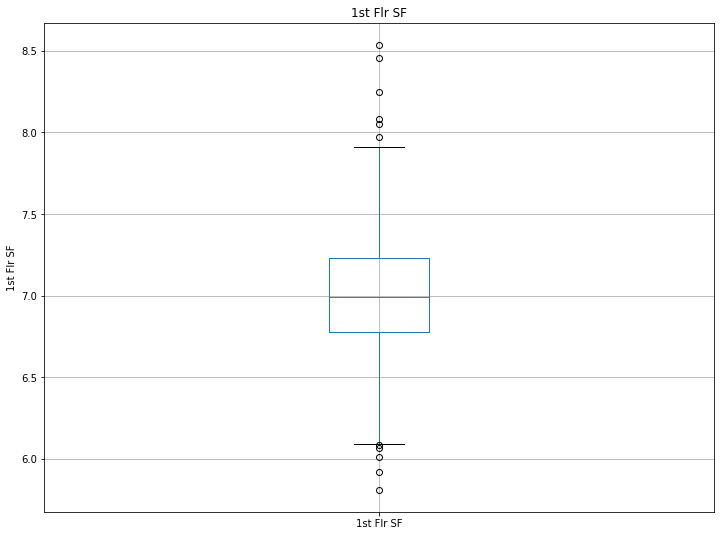

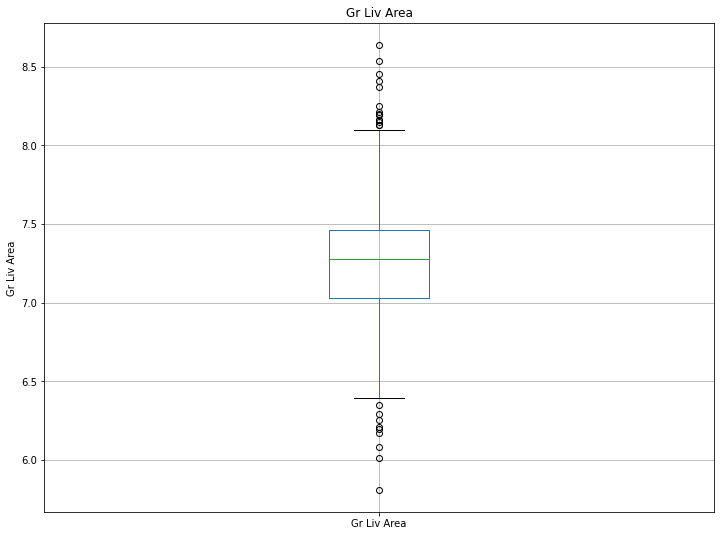

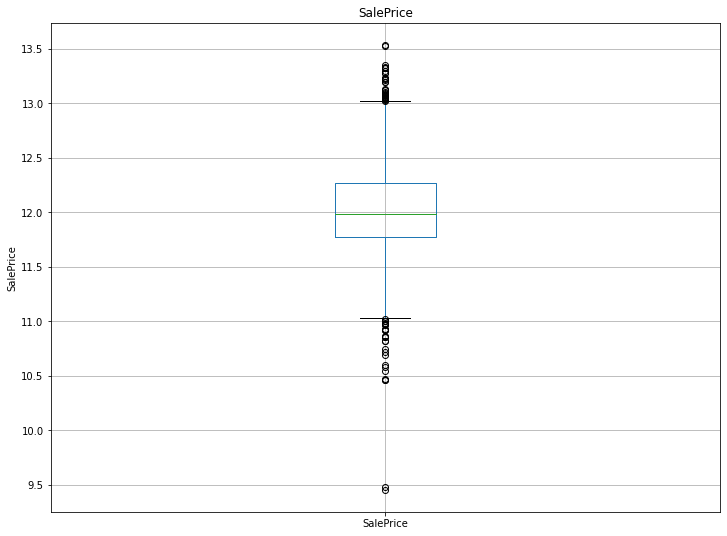

In [24]:
for cols in continous_cols:
  if 0 in df[cols].unique():
        pass
  else:
    plt.figure(figsize=(12,9))
    df.boxplot(column=cols)
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()

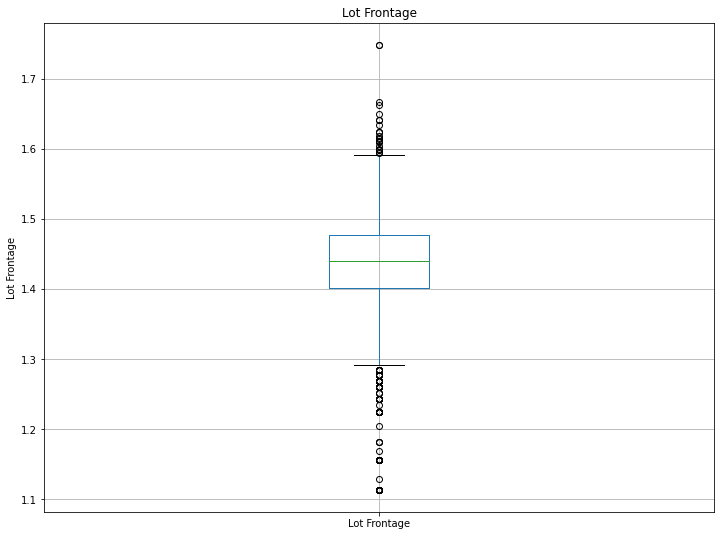

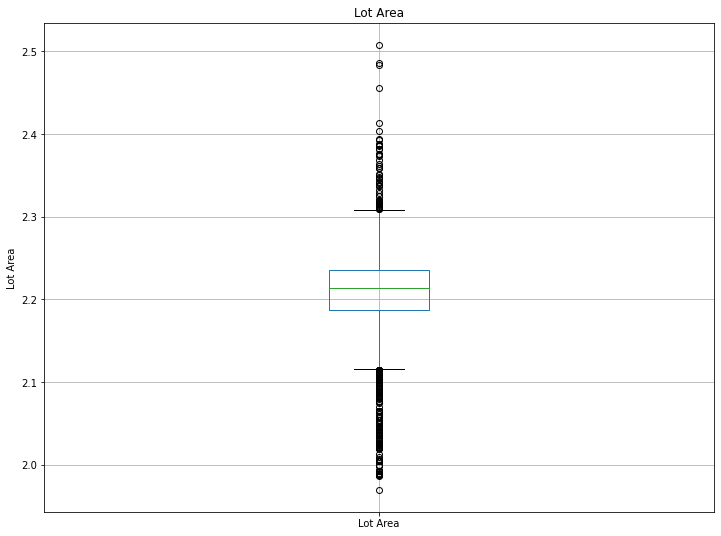

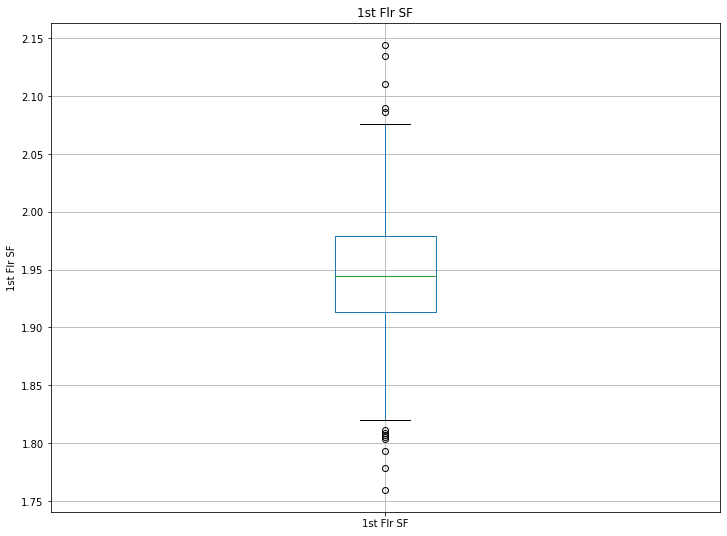

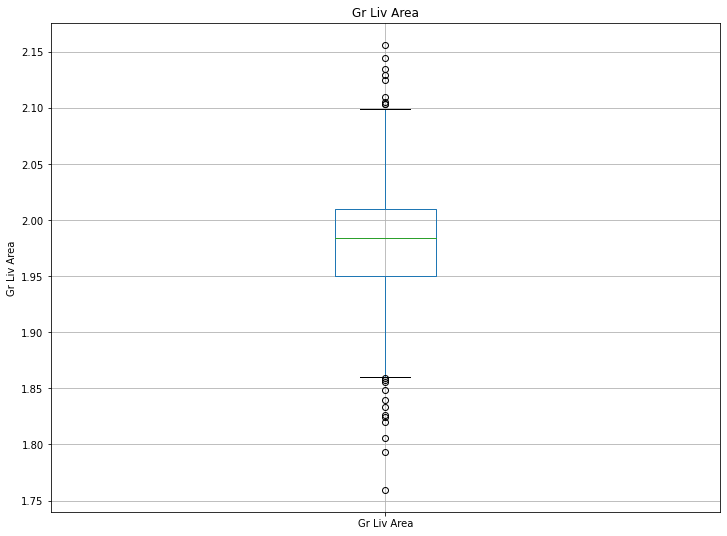

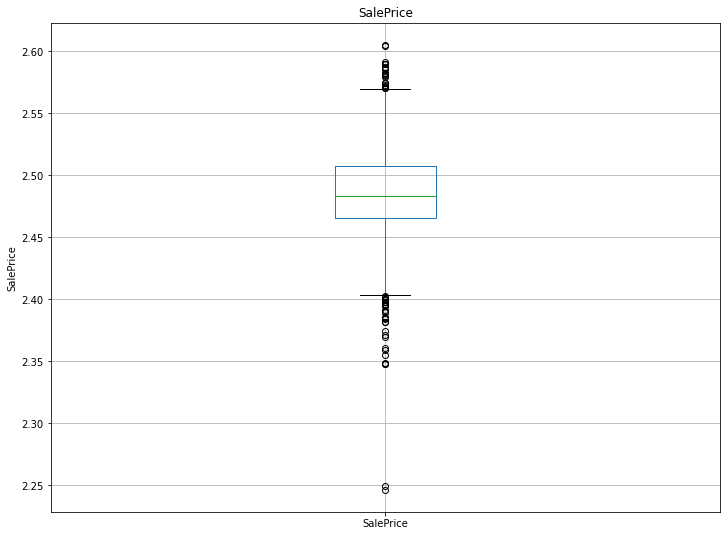

In [25]:
for cols in continous_cols:
  if 0 in df[cols].unique():
        pass
  else:
    plt.figure(figsize=(12,9))
    df[cols]=np.log(df[cols])
    df.boxplot(column=cols)
    plt.ylabel(cols)
    plt.title(cols)
    plt.show()

# Filling Categorical Columns 
By Reading the description of feature from the provided file filling the Null values.

Categorical Columns containing the Null values

In [26]:
cat_null=df[categorical_columns].isna().sum()
cat_null[cat_null>0]

Alley             2732
Mas Vnr Type        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin Type 2      81
Electrical           1
Fireplace Qu      1422
Garage Type        157
Garage Finish      159
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

In [27]:
df['Electrical']=df['Electrical'].fillna('SBrkr') #Filling with most frequent columns
df['Fence']=df['Fence'].fillna('No Fence')
df['Bsmt Qual']=df['Bsmt Qual'].fillna('No Basement')
df['Bsmt Cond']=df['Bsmt Cond'].fillna('No Basement')
df['Bsmt Exposure']=df['Bsmt Exposure'].fillna('No Basement')
df['BsmtFin Type 1']=df['BsmtFin Type 1'].fillna('No Basement')
df['BsmtFin Type 2']=df['BsmtFin Type 2'].fillna('No Basement')
df['Garage Type']=df['Garage Type'].fillna('No Garage')
df['Garage Finish']=df['Garage Finish'].fillna('No Garage')
df['Garage Qual']=df['Garage Qual'].fillna('No Garage')
df['Garage Cond']=df['Garage Cond'].fillna('No Garage')
df["Misc Feature"] = df["Misc Feature"].fillna("None")
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna("None")
df['Alley']=df['Alley'].fillna('No Alley Access')
df['Fireplace Qu']=df['Fireplace Qu'].fillna('No Fireplace')
df["Pool QC"] = df["Pool QC"].fillna("No Pool")

# Filling Numerical Columns
From above boxplots we can see that there are outliers and after reviewing the data description if there's any value which need to be filled with **mean or median or mode** other then **0** then we will avoid using **mean** because of outliers 

In [28]:
num_null=df[numerical_cols].isna().sum()
num_null[num_null>0]

Lot Frontage        490
Mas Vnr Area         23
BsmtFin SF 1          1
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Yr Blt       159
Garage Cars           1
Garage Area           1
Total BsmtFin SF      1
Bsmt fn               1
Total Baths           2
dtype: int64

In [29]:
df["Lot Frontage"] = df.groupby("Neighborhood")["Lot Frontage"].transform(lambda x: x.fillna(x.median())) # using median to avoid the trap of outliers
# data description shows that 'NA' means no value so just replace it with 0
df['Garage Yr Blt']=df['Garage Yr Blt'].fillna(0)
df['Garage Area']=df['Garage Area'].fillna(0)
df['Garage Cars']=df['Garage Cars'].fillna(0)
df['Bsmt Full Bath']=df['Bsmt Full Bath'].fillna(0)
df['Bsmt Half Bath']=df['Bsmt Half Bath'].fillna(0)
df['Total Bsmt SF']=df['Total Bsmt SF'].fillna(0)
df['BsmtFin SF 1']=df['BsmtFin SF 1'].fillna(0)
df['BsmtFin SF 2']=df['BsmtFin SF 2'].fillna(0)
df['Bsmt Unf SF']=df['Bsmt Unf SF'].fillna(0)
df["Mas Vnr Area"] = df["Mas Vnr Area"].fillna(0)

In [30]:
df=df.dropna()
print(df.isna().sum())

MS SubClass         0
MS Zoning           0
Lot Frontage        0
Lot Area            0
Street              0
                   ..
SalePrice           0
Total BsmtFin SF    0
Bsmt fn             0
Total Baths         0
Total Porch         0
Length: 84, dtype: int64


## Feature Engineering

In [31]:
df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

Talking the years columns and checking it's relationship with sales price

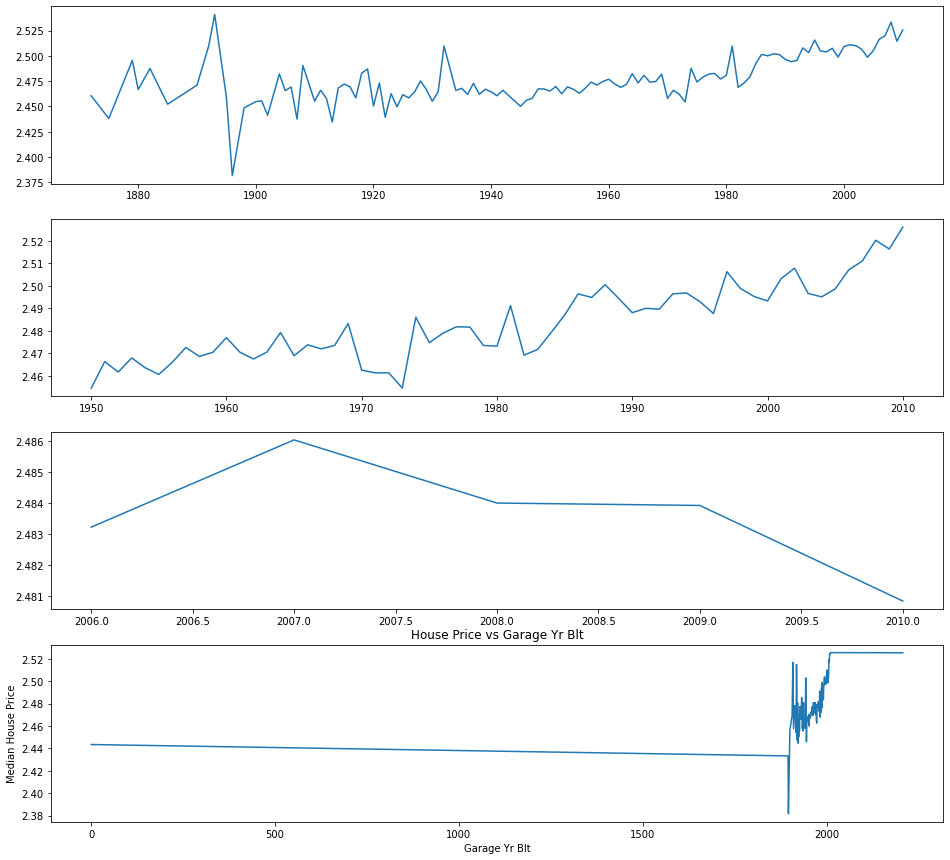

In [32]:
fig, axs = plt.subplots(4,figsize=(16,15))
for i,year_col in enumerate(years_cols):
  axs[i].plot(df.groupby(year_col)['SalePrice'].median())
  plt.xlabel(year_col)
  plt.ylabel('Median House Price')
  plt.title(f"House Price vs {year_col}")

There's is an unusal pattern in the data shows that as the yearsold increases the prices decreases.
 Applying techniques to get only the years that how old is the house is by subtracting the year it built from Yr it sold similarly for all other columns. So it will give us better idea of how old the house was at the time of selling, How many years ago it was modified 

In [33]:
for year_cols in ['Year Built','Year Remod/Add']:
    df[year_cols]=df['Yr Sold']-df[year_cols]

In [34]:
for col in categorical_columns:
  print(col)
  print(df[col].value_counts())
  print('*'*100)

MS Zoning
RL         2272
RM          459
FV          139
RH           26
C (all)      25
I (all)       2
A (agr)       2
Name: MS Zoning, dtype: int64
****************************************************************************************************
Street
Pave    2913
Grvl      12
Name: Street, dtype: int64
****************************************************************************************************
Alley
No Alley Access    2727
Grvl                120
Pave                 78
Name: Alley, dtype: int64
****************************************************************************************************
Lot Shape
Reg    1859
IR1     974
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
****************************************************************************************************
Land Contour
Lvl    2628
HLS     120
Bnk     117
Low      60
Name: Land Contour, dtype: int64
**************************************************************************************************

In [35]:
for cols in categorical_columns:
  lbe = LabelEncoder()
  lbe.fit(list(df[cols].values))
  df[cols] = lbe.transform(list(df[cols].values))

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MS SubClass       2925 non-null   int64  
 1   MS Zoning         2925 non-null   int64  
 2   Lot Frontage      2925 non-null   float64
 3   Lot Area          2925 non-null   float64
 4   Street            2925 non-null   int64  
 5   Alley             2925 non-null   int64  
 6   Lot Shape         2925 non-null   int64  
 7   Land Contour      2925 non-null   int64  
 8   Utilities         2925 non-null   int64  
 9   Lot Config        2925 non-null   int64  
 10  Land Slope        2925 non-null   int64  
 11  Neighborhood      2925 non-null   int64  
 12  Condition 1       2925 non-null   int64  
 13  Condition 2       2925 non-null   int64  
 14  Bldg Type         2925 non-null   int64  
 15  House Style       2925 non-null   int64  
 16  Overall Qual      2925 non-null   int64  


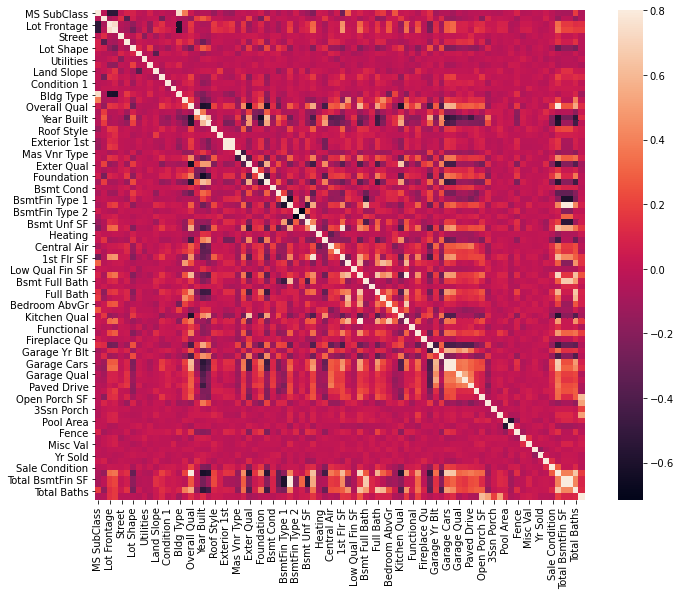

In [37]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

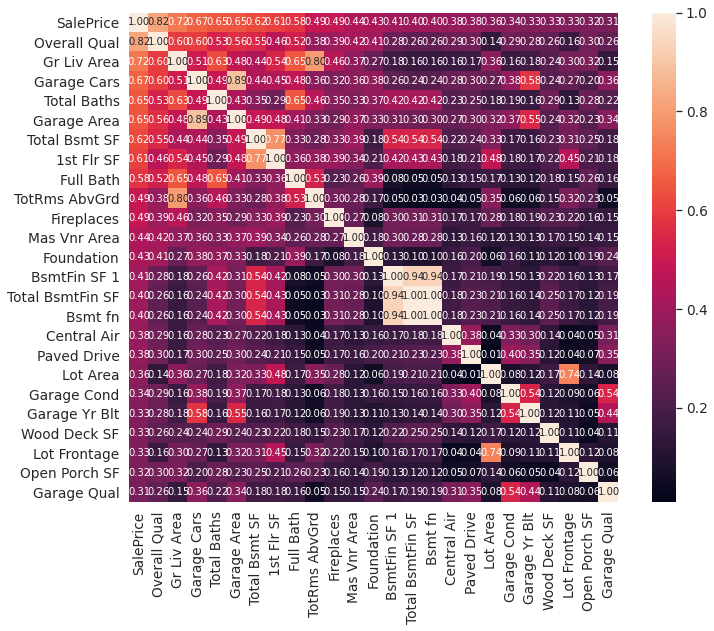

In [38]:
k = 25
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(12,9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [39]:
df=df[cols]

Droping columns to avoid multi collinearity

In [40]:
df=df.drop(['TotRms AbvGrd','Garage Area','Total BsmtFin SF','Bsmt fn'],axis=1)

In [41]:
df.head()

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Total Baths,Total Bsmt SF,1st Flr SF,Full Bath,Fireplaces,Mas Vnr Area,Foundation,BsmtFin SF 1,Central Air,Paved Drive,Lot Area,Garage Cond,Garage Yr Blt,Wood Deck SF,Lot Frontage,Open Porch SF,Garage Qual
0,2.507841,6,2.003122,2.0,2.0,1080.0,2.003122,1,2,112.0,1,639.0,1,1,2.338558,5,1960.0,210,1.599137,62,5
1,2.447699,5,1.916620,1.0,1.0,882.0,1.916620,1,0,0.0,1,468.0,1,2,2.236515,5,1961.0,140,1.477511,0,5
2,2.489500,6,1.972995,1.0,2.0,1329.0,1.972995,1,0,108.0,1,923.0,1,2,2.258184,5,1958.0,393,1.480342,36,5
3,2.518093,7,2.035286,2.0,4.0,2110.0,2.035286,2,2,0.0,1,1065.0,1,2,2.232172,5,1968.0,0,1.511296,0,5
4,2.497679,5,2.000902,2.0,3.0,928.0,1.921768,2,1,0.0,2,791.0,1,2,2.254927,5,1997.0,212,1.459560,34,5


In [42]:
def rmse_func(mse):
  return np.sqrt(mse)

In [43]:
X=df.drop('SalePrice',axis=1)
y=df['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

Without scaling features

In [44]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
y_pred=lr.predict(X_test)

In [46]:
lr_mse=mean_squared_error(y_test,y_pred)
lr_rmse=rmse_func(lr_mse)
print('mean squarred error :',lr_mse)
print('root mean squarred error :',lr_rmse)

mean squarred error : 0.00018833483430960842
root mean squarred error : 0.013723513919897063


In [47]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
preds=rf.predict(X_test)
rf_mse=mean_squared_error(y_test,preds)
rf_rmse=rmse_func(rf_mse)
print('mean squarred error :',rf_mse)
print('root mean squarred error :',rf_rmse)

mean squarred error : 0.00017762836673953676
root mean squarred error : 0.013327729241680172


In [49]:
svrgs_parameters = {
    'kernel': ['rbf'],
    'C':     [150000,200000,250000],
    'gamma': [0.004,0.0045,0.005]
}
svr = GridSearchCV(SVR(), svrgs_parameters, cv=8, scoring= 'neg_mean_squared_log_error')
svr.fit(X_train, y_train)

GridSearchCV(cv=8, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [150000, 200000, 250000],
                         'gamma': [0.004, 0.0045, 0.005], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_log_error', verbose=0)

In [50]:
preds = svr.best_estimator_.predict(X_test)

In [51]:
svm_mse=mean_squared_error(y_test,preds)
svm_rmse=rmse_func(svm_mse)
print('mean squarred error :',svm_mse)
print('root mean squarred error :',svm_rmse)

mean squarred error : 0.0015850935381790214
root mean squarred error : 0.039813233204288014


## Applying Feature scaling

In [52]:
mms=MinMaxScaler()
X_train_scaled=mms.fit_transform(X_train)

In [53]:
X_test_scaled = mms.transform(X_test)
y_preds = lr.predict(X_test_scaled)

In [54]:
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.fit(X_train_scaled,y_train)
y_preds=lr.predict(X_test_scaled)

In [55]:
from sklearn.metrics import mean_absolute_error

In [56]:
lr_mse_scale=mean_squared_error(y_test,y_preds)
lr_mae_scale=mean_absolute_error(y_test,y_preds)
print('mean squarred error :',lr_mse_scale)
print('mean squarred error :',lr_mae_scale)

mean squarred error : 0.00018833483430962344
mean squarred error : 0.008353670295288763


In [57]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
preds=rf.predict(X_test_scaled)
rf_mse_scaled=mean_squared_error(y_test,preds)
rf_mae_scaled=mean_absolute_error(y_test,y_preds)
print('mean squarred error :',rf_mse_scaled)
print('mean absolute error :',rf_mae_scaled)

mean squarred error : 0.000179504764754744
mean absolute error : 0.008353670295288763


From here we selected the features and correlation metrix we findout the important features

Text(0.5, 0, 'Random Forest Feature Importance')

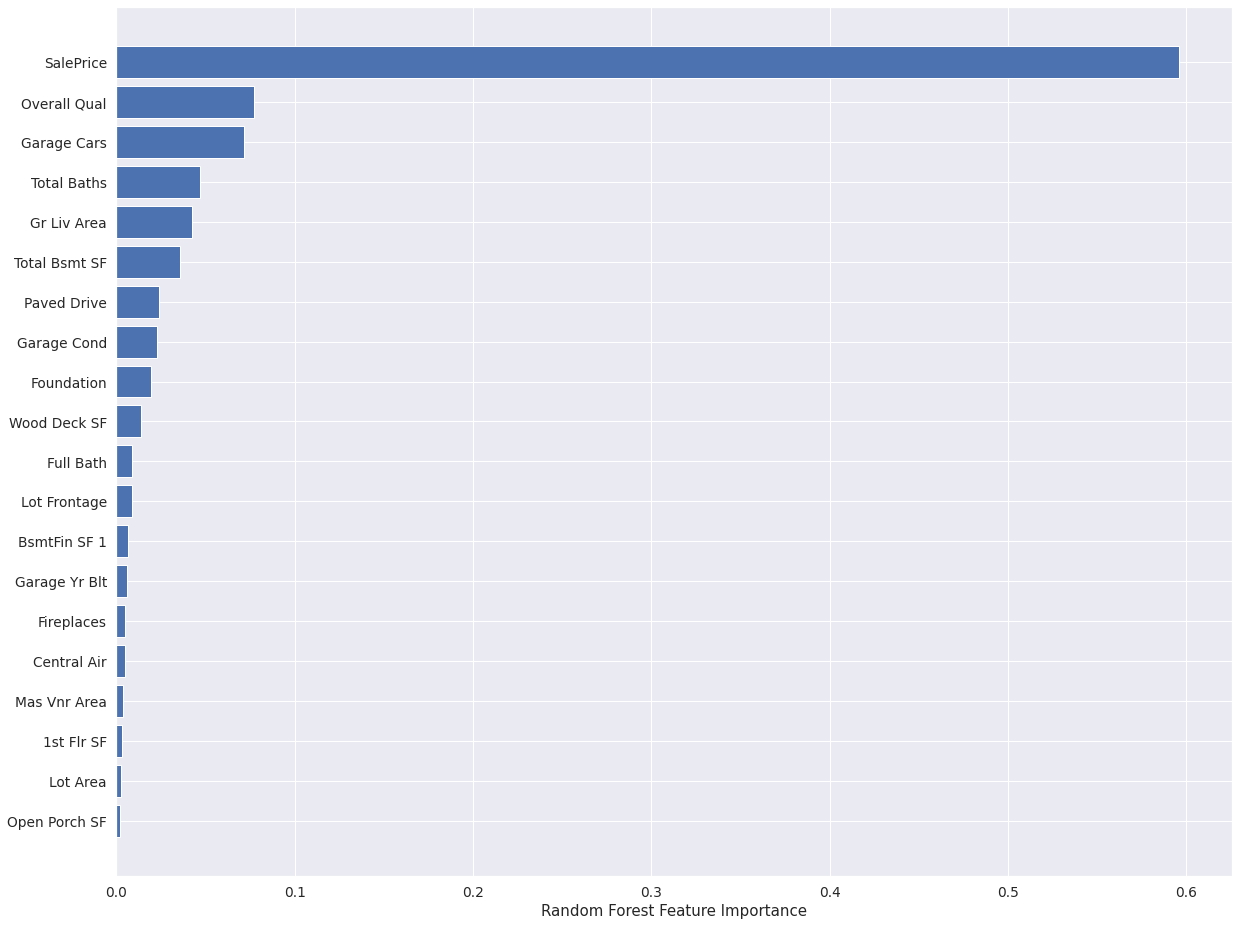

In [59]:
plt.figure(figsize=(20,16))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.columns[sorted_idx], rf.feature_importances_[sorted_idx]);
plt.xlabel("Random Forest Feature Importance")

In [60]:
svrgs_parameters = {
    'kernel': ['rbf'],
    'C':     [150000,200000,250000],
    'gamma': [0.004,0.0045,0.005]
}
svr = GridSearchCV(SVR(), svrgs_parameters, cv=8, scoring= 'neg_mean_squared_log_error')
svr.fit(X_train_scaled, y_train)

GridSearchCV(cv=8, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [150000, 200000, 250000],
                         'gamma': [0.004, 0.0045, 0.005], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_log_error', verbose=0)

In [61]:
prediction = svr.best_estimator_.predict(X_test_scaled)

In [62]:
svm_mse_scale=mean_squared_error(y_test,prediction)
svm_mae_scale=mean_absolute_error(y_test,y_preds)
print('mean squarred error :',svm_mse_scale)
print('mean absolute error :',svm_mae_scale)

mean squarred error : 0.001382127118288878
mean absolute error : 0.008353670295288763


Converting score into single list

In [63]:
scaled_mse=[lr_mse_scale,rf_mse_scaled,svm_mse_scale]
scaled_mae=[lr_mae_scale,rf_mae_scaled,svm_mae_scale]

In [64]:
unscaled_mse=[lr_mse,rf_mse,svm_mse]
unscaled_rmse=[lr_rmse,rf_rmse,svm_rmse]

Models Performance on Scaled data

In [65]:
df_scaled_mse=pd.DataFrame(scaled_mse,index=['Linear Reg','Random Forest','SVR'])

In [66]:
df_scaled_mae=pd.DataFrame(scaled_mae,index=['Linear Reg','Random Forest','SVR'])

In [67]:
df_scaled=pd.merge(df_scaled_mse,df_scaled_mae,on=df_scaled_mse.index)
df_scaled.columns=['Models','mse','mae']
df_scaled

,Models,mse,mae
0,Linear Reg,0.000188,0.008354
1,Random Forest,0.000180,0.008354
2,SVR,0.001382,0.008354


Models Performance on un Scaled data

In [68]:
df_unscaled_mse=pd.DataFrame(unscaled_mse,index=['Linear Reg','Random Forest','SVR'])

In [69]:
df_unscaled_rmse=pd.DataFrame(unscaled_rmse,index=['Linear Reg','Random Forest','SVR'])

In [70]:
df_unscaled=pd.merge(df_unscaled_mse,df_unscaled_rmse,on=df_unscaled_mse.index)
df_unscaled.columns=['Models','mse','rmse']
df_unscaled

,Models,mse,rmse
0,Linear Reg,0.000188,0.013724
1,Random Forest,0.000178,0.013328
2,SVR,0.001585,0.039813
